In [ ]:
!python -m pip install git+https://github.com/greydanus/mnist1d.git@master

!git clone https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d.git (to revision master) to /tmp/pip-req-build-fexm7fes
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d.git /tmp/pip-req-build-fexm7fes
  Resolved https://github.com/greydanus/mnist1d.git to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post16-py3-none-any.whl size=14626 sha256=d5103b85a9592b163dd71da78f919aa59669da40bd4e20922c9a551a5c297645
  Stored in directory: /tmp/pip-ephem-wheel-cache-lg4gz743/wheels/d7/f4/df/433336ddc98ff899ac4db5b8c4230819d9c130d002cc400cd8
Successfully built mnist1d
Cloning into 'mnist1d'...
remote: Enumerating objects: 541, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 541 (delta 120), reused 119 (delta 119), pack-

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.ndimage import gaussian_filter
import torch.optim as optim
import matplotlib.pylab as pl
import torch, os,time
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import mnist1d

In [ ]:
%matplotlib inline

import pylab as plt
import numpy as np


In [ ]:
from mnist1d.data import get_dataset, get_dataset_args
from mnist1d.utils import set_seed, to_pickle, from_pickle

import sys ; sys.path.append('/content/mnist1d/notebooks')
from train import get_model_args, train_model

In [ ]:
args = get_dataset_args()
data = get_dataset(args=args)

Saving to ./mnist1d_data.pkl
Successfully loaded data from ./mnist1d_data.pkl


In [ ]:
class SparseLinear(torch.nn.Module):
  def __init__(self, x_size, y_size):
    super(SparseLinear, self).__init__()
    self.linear = torch.nn.Linear(x_size, y_size)
    param_vec = torch.cat([p.flatten() for p in self.parameters()])
    self.mask = torch.ones_like(param_vec)

  def forward(self, x, apply_mask=True):
    if apply_mask:
      self.apply_mask()
    return self.linear(x)

  def update_mask(self, new_mask):
    self.mask = new_mask
    self.apply_mask()

  def apply_mask(self):
    self.vec2param(self.param2vec())

  def param2vec(self):
    vec = torch.cat([p.flatten() for p in self.parameters()])
    return self.mask * vec

  def vec2param(self, vec):
    pointer = 0
    for param in self.parameters():
      param_len = np.cumprod(param.shape)[-1]
      new_param = vec[pointer:pointer+param_len].reshape(param.shape)
      param.data = new_param.data
      pointer += param_len

class SparseMLP(torch.nn.Module):
  def __init__(self, input_size, output_size, hidden_size=100):
    super(SparseMLP, self).__init__()
    self.linear1 = SparseLinear(input_size, hidden_size)
    self.linear2 = SparseLinear(hidden_size, hidden_size)
    self.linear3 = SparseLinear(hidden_size, output_size)
    self.layers = [self.linear1, self.linear2, self.linear3]

  def forward(self, x):
    h = torch.relu(self.linear1(x))
    h = h + torch.relu(self.linear2(h))
    h = self.linear3(h)
    return h

  def get_layer_masks(self):
    return [l.mask for l in self.layers]

  def set_layer_masks(self, new_masks):
    for i, l in enumerate(self.layers):
      l.update_mask(new_masks[i])

  def get_layer_vecs(self):
    return [l.param2vec() for l in self.layers]

  def set_layer_vecs(self, vecs):
    for i, l in enumerate(self.layers):
      l.vec2param(vecs[i])

In [ ]:
def get_mask(scores, percent_sparse):

    # Calculate the number of weights to drop
    num_to_drop = int(percent_sparse * scores.numel())

    # Get the indices of weights with the lowest scores
    ixs_to_drop = torch.argsort(scores)[:num_to_drop]  # Sort by score, select lowest `num_to_drop` scores

    # Initialize the mask with ones (retain all initially)
    mask = torch.ones_like(scores)

    # Set indices of lowest-scored weights to 0
    mask[ixs_to_drop] = 0

    return mask


In [ ]:
def find_lottery_ticket(model, dataset, args, sparsity_schedule, criteria_fn=None,
                        prune_print_every=None, **kwargs):
  if prune_print_every is None:
    prune_print_every = np.inf

  if criteria_fn is None:
    print("Using default magnitude-based pruning")
    criteria_fn = lambda init_params, final_params: final_params.abs()

  init_params = model.get_layer_vecs()
  stats = {'train_losses':[], 'test_losses':[], 'train_accs':[], 'test_accs':[]}
  models = []
  for i, percent_sparse in enumerate(sparsity_schedule):

    # layer-wise pruning, where pruning heuristic is determined by criteria_fn
    final_params = model.get_layer_vecs()
    scores = [criteria_fn(ip, fp) for ip, fp in zip(init_params, final_params)]
    masks = [get_mask(s, percent_sparse) for s in scores]

    # update model with mask and init parameters
    model.set_layer_vecs(init_params)
    model.set_layer_masks(masks)

    # training process
    results = train_model(dataset, model, args)
    model = results['checkpoints'][-1]

    # store stats
    stats['train_losses'].append(results['train_losses'])
    stats['test_losses'].append(results['test_losses'])
    stats['train_accs'].append(results['train_acc'])
    stats['test_accs'].append(results['test_acc'])

    # print progress
    if (i+1) % prune_print_every == 0:
      print('\tretrain #{}, sparsity {:.2f}, final_train_loss {:.3e}, max_acc {:.1f}, last_acc {:.1f}, mean_acc {:.1f}'
            .format(i+1, percent_sparse, results['train_losses'][-1], np.max(results['test_acc']),
            results['test_acc'][-1], np.mean(results['test_acc']) ))
      models.append(copy.deepcopy(model))

  stats = {k: np.stack(v) for k, v in stats.items()}
  return models, stats

In [ ]:
# train settings
model_args = get_model_args()
model_args.total_steps = 1501
model_args.hidden_size = 500
model_args.print_every = 5000
model_args.eval_every = 100
model_args.learning_rate = 2e-2


# sparsity settings
num_retrains = 100
sparsity_schedule = np.exp(np.linspace(0, -1, num_retrains))

Exponential sparsity schedule, (above cell)

In [ ]:
num_trials = 2
trials = {'rand_models': [], 'rand_stats': [], 'lott_models': [], 'lott_stats': []}

In [ ]:
for t in range(num_trials):
  print("############  Trial {}  ############".format(t))
  print("   Random pruning")
  set_seed(model_args.seed+t)
  model = SparseMLP(model_args.input_size, model_args.output_size, hidden_size=model_args.hidden_size)

  def criteria_fn(init_params, final_params):
    mask = (final_params == 0).int()  # if params are already set to zero, keep them set to zero
    return torch.rand(final_params.shape) #* mask
  models, stats = find_lottery_ticket(model, data, model_args, sparsity_schedule,
                                      criteria_fn=criteria_fn, prune_print_every=1)
  trials['rand_models'].append(models)
  trials['rand_stats'].append(stats)

  print("   Magnitude pruning")
  set_seed(model_args.seed+t)
  model = SparseMLP(model_args.input_size, model_args.output_size, hidden_size=model_args.hidden_size)
  criteria_fn = lambda init_params, final_params: final_params.abs()
  models, stats = find_lottery_ticket(model, data, model_args, sparsity_schedule,
                  criteria_fn=criteria_fn, prune_print_every=1)
  trials['lott_models'].append(models)
  trials['lott_stats'].append(stats)

############  Trial 0  ############
   Random pruning
	retrain #1, sparsity 1.00, final_train_loss 2.303e+00, max_acc 10.2, last_acc 10.2, mean_acc 10.2
	retrain #2, sparsity 0.99, final_train_loss 2.201e+00, max_acc 17.4, last_acc 15.8, mean_acc 16.4
	retrain #3, sparsity 0.98, final_train_loss 1.652e+00, max_acc 33.9, last_acc 33.3, mean_acc 29.4
	retrain #4, sparsity 0.97, final_train_loss 1.092e+00, max_acc 41.9, last_acc 41.1, mean_acc 37.5
	retrain #5, sparsity 0.96, final_train_loss 7.804e-01, max_acc 49.7, last_acc 47.7, mean_acc 44.6
	retrain #6, sparsity 0.95, final_train_loss 4.051e-01, max_acc 55.4, last_acc 55.4, mean_acc 48.8
	retrain #7, sparsity 0.94, final_train_loss 3.600e-01, max_acc 55.3, last_acc 52.8, mean_acc 49.6
	retrain #8, sparsity 0.93, final_train_loss 1.389e-01, max_acc 58.4, last_acc 58.4, mean_acc 52.2
	retrain #9, sparsity 0.92, final_train_loss 7.728e-02, max_acc 60.2, last_acc 57.8, mean_acc 53.4
	retrain #10, sparsity 0.91, final_train_loss 2.044e-01

In [ ]:
to_pickle(trials, path='/content/sparsity_schedule_exponential.pkl')

In [ ]:
trials = from_pickle('/content/sparsity_schedule_exponential.pkl')

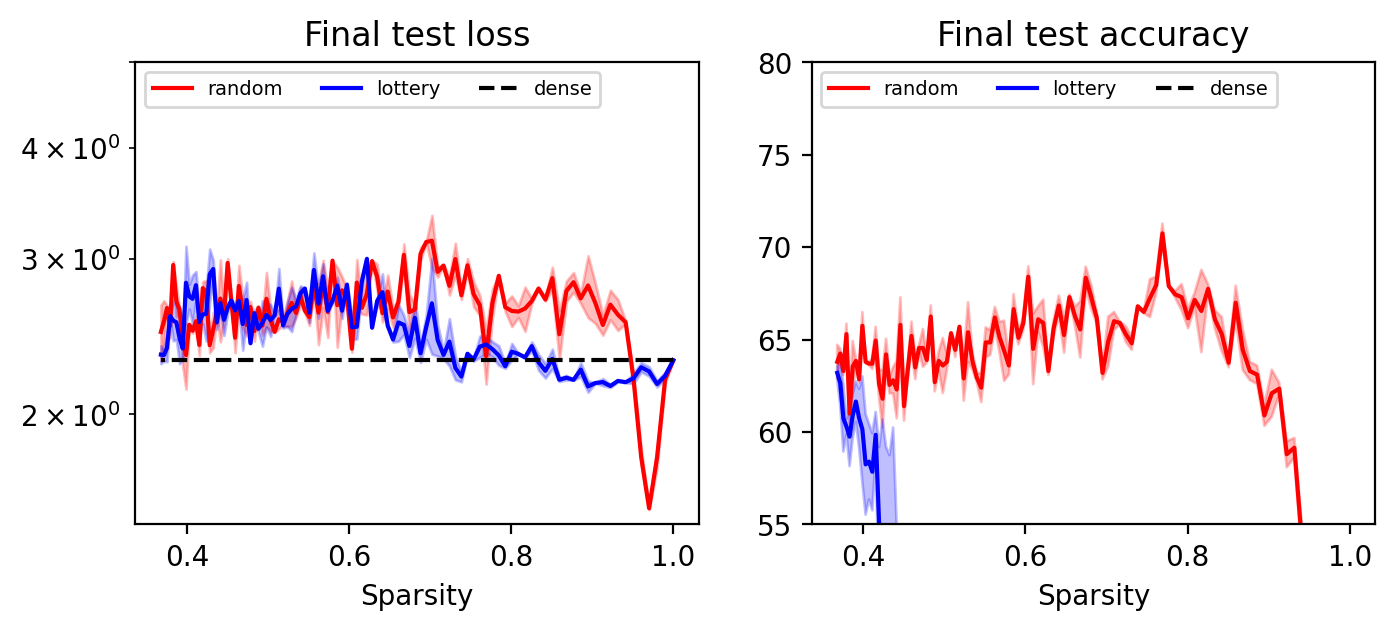

In [ ]:
def average_over(trials, trial_name, key):
    ys = [trials[trial_name][i][key] for i in range(len(trials[trial_name]))]
    return np.stack(ys).mean(0), np.stack(ys).std(0) / np.sqrt(len(ys))
x = sparsity_schedule
# Define colors and figure
rand_color, lott_color = 'r', 'b'
fig = plt.figure(figsize=[8, 3], dpi=200)

# Plotting Final Test Loss
plt.subplot(1, 2, 1)
for trial_name, color, label in zip(['rand_stats', 'lott_stats'], [rand_color, lott_color], ['random', 'lottery']):
    y, y_err = average_over(trials, trial_name, 'test_losses')
    y, y_err = y[:, -1], y_err[:, -1]
    plt.plot(x, y, '-', color=color, label=label)
    plt.fill_between(x, y - y_err, y + y_err, color=color, alpha=0.25)

plt.plot(x, np.ones_like(x) * y[0], 'k--', label='dense')
plt.xlabel('Sparsity')
plt.title('Final test loss')
plt.yscale('log')
plt.ylim(None, 5e0)
plt.legend(fontsize=7, ncol=3, loc='upper left')

# Plotting Final Test Accuracy
plt.subplot(1, 2, 2)
for trial_name, color, label in zip(['rand_stats', 'lott_stats'], [rand_color, lott_color], ['random', 'lottery']):
    y, y_err = average_over(trials, trial_name, 'test_accs')
    y, y_err = y[:, -1], y_err[:, -1]
    plt.plot(x, y, '-', color=color, label=label)
    plt.fill_between(x, y - y_err, y + y_err, color=color, alpha=0.25)

plt.plot(x, np.ones_like(x) * y[0], 'k--', label='dense')
plt.xlabel('Sparsity')
plt.title('Final test accuracy')
plt.ylim(55, 80)
plt.legend(fontsize=7, ncol=3, loc='upper left')

plt.show()

**Exponetial sparsity schedule is not advantageous over linear schedule**